In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# veri setini okuma
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [82]:
# veri tiplerini inceleme
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [83]:
# Null olan değerler var mı kontrolü
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [84]:
#Yinelenen veri kontrolü
df.duplicated().sum()

0

In [85]:
df.info

<bound method DataFrame.info of         price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no

In [86]:
# kategorik verileri dönüştürme
label_encoder = LabelEncoder()

df['airconditioning'] = label_encoder.fit_transform(df['airconditioning'])
df["hotwaterheating"] = label_encoder.fit_transform(df["hotwaterheating"])
df["mainroad"] = label_encoder.fit_transform(df["mainroad"])
df["basement"] = label_encoder.fit_transform(df["basement"])
df["guestroom"] = label_encoder.fit_transform(df["guestroom"])
df["prefarea"] = label_encoder.fit_transform(df["prefarea"])
df["furnishingstatus"] = label_encoder.fit_transform(df["furnishingstatus"])

df.info

<bound method DataFrame.info of         price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0    13300000  7420         4          2        3         1          0   
1    12250000  8960         4          4        4         1          0   
2    12250000  9960         3          2        2         1          0   
3    12215000  7500         4          2        2         1          0   
4    11410000  7420         4          1        2         1          1   
..        ...   ...       ...        ...      ...       ...        ...   
540   1820000  3000         2          1        1         1          0   
541   1767150  2400         3          1        1         0          0   
542   1750000  3620         2          1        1         1          0   
543   1750000  2910         3          1        1         0          0   
544   1750000  3850         3          1        2         1          0   

     basement  hotwaterheating  airconditioning  parking  prefarea  \
0        

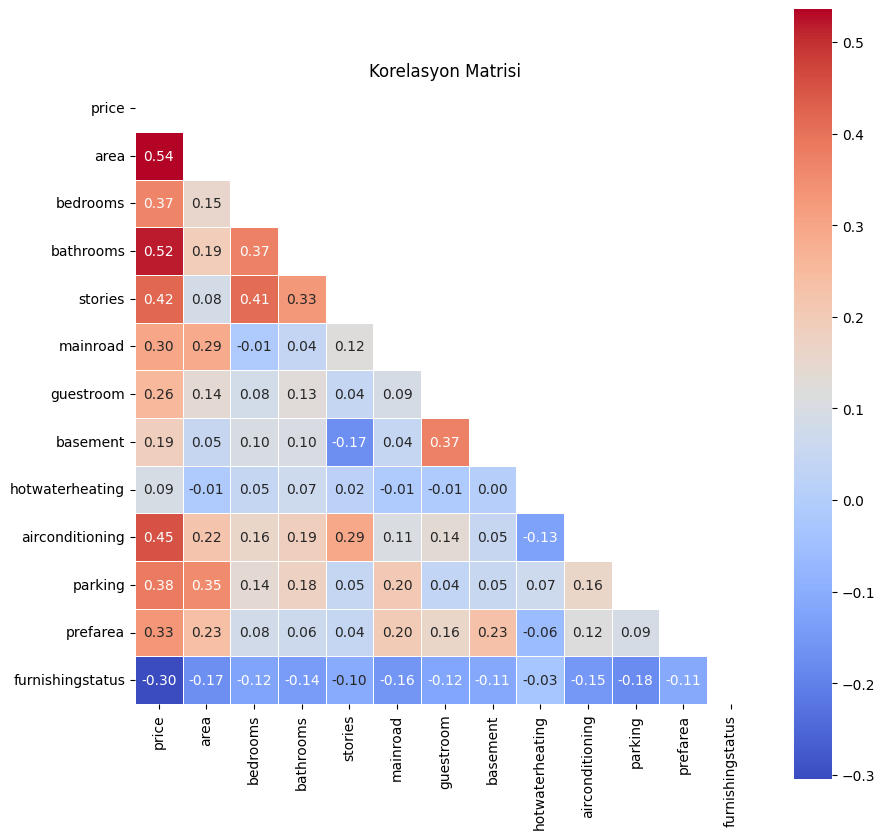

In [87]:
# korelasyon matrisi
plt.figure(figsize=(10, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="coolwarm", mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, fmt=".2f", annot_kws={"size": 10}, linewidths=0.5, square=True)
plt.title("Korelasyon Matrisi")
plt.show()

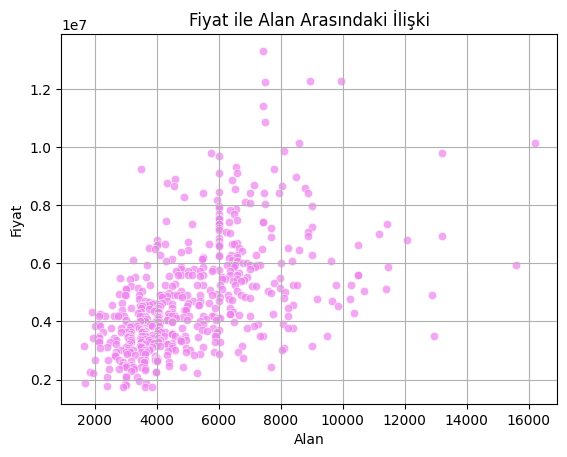

In [88]:
# price ile area arasındaki ilişki
sns.scatterplot(data=df, x='area', y='price', color='violet', alpha=0.7)
plt.title('Fiyat ile Alan Arasındaki İlişki')
plt.xlabel('Alan')
plt.ylabel('Fiyat')
plt.grid(True)
plt.show()

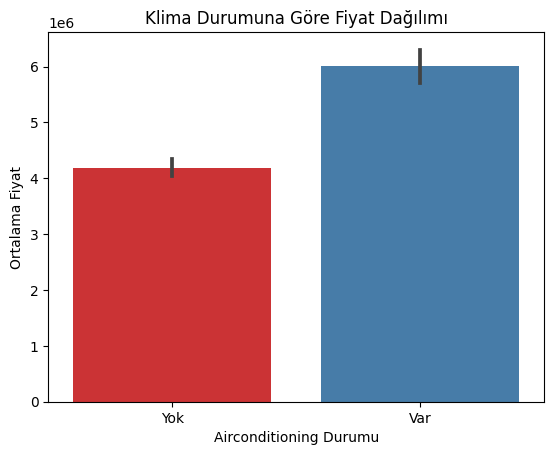

In [89]:
# airconditioning ve price arasındaki ilişki
ax = sns.barplot(data=df, x='airconditioning', y='price', palette='Set1')
ax.set_xticklabels(['Yok', 'Var'])#Sayısallaştırdığım veriyi tekrar kategorik hale getiriyorum
plt.title('Klima Durumuna Göre Fiyat Dağılımı')
plt.xlabel('Airconditioning Durumu')
plt.ylabel('Ortalama Fiyat')
plt.show()

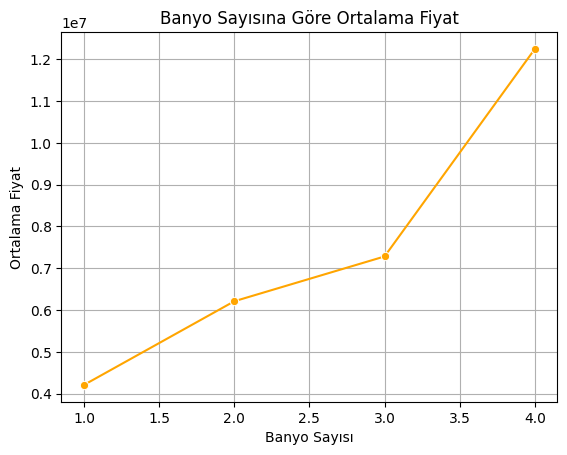

In [90]:
# bathrooms ve price aarasındaki ilişki
OrtPriceBath = df.groupby('bathrooms')['price'].mean()#banyo sayısına göre ortalama fiyatı gösteren seri oluşturduk
sns.lineplot(x=OrtPriceBath.index, y=OrtPriceBath.values, marker='o', color='orange',)
plt.title('Banyo Sayısına Göre Ortalama Fiyat')
plt.xlabel('Banyo Sayısı')
plt.ylabel('Ortalama Fiyat')
plt.grid(True)
plt.show()

In [91]:
# price hedef değişken olarak ayırma
x = df.drop("price", axis=1)
y = df["price"]

# train test split işlemleri
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)


In [92]:
# xgb için Gridsearch kullanma
xgbParams = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# XGBoost modelini GPU kullanarak oluşturma
xgbModel = XGBRegressor(random_state=42, tree_method='gpu_hist', gpu_id=0)
xgbGridSearch = GridSearchCV(estimator=xgbModel, param_grid=xgbParams, scoring='neg_mean_squared_error', cv=5, verbose = 0)
xgbGridSearch.fit(x_train, y_train)

# en iyi parametreleri bulma
bestParamsXGB = xgbGridSearch.best_params_
bestmseXGB = -xgbGridSearch.best_score_

In [93]:
# lgbm için Gridsearch kullanma
lgbmParams = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'verbosity': [-1]
}

# LightGBM modelini GPU kullanarak oluşturma
lgbmModel = LGBMRegressor(random_state=42, device='gpu')
lgbmGridSearch = GridSearchCV(estimator=lgbmModel, param_grid=lgbmParams, scoring='neg_mean_squared_error', cv=5, verbose = 0)
lgbmGridSearch.fit(x_train, y_train)

# en iyi parametreleri bulma
bestParamsLGBM = lgbmGridSearch.best_params_
bestmseLGBM = -lgbmGridSearch.best_score_


In [ ]:
# CatBoost için Gridsearch kullanma
catbParams = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# CatBoost modelini GPU kullanarak oluşturma
catbModel = CatBoostRegressor(random_state=42, verbose=0, task_type='GPU')
catbGridSearch = GridSearchCV(estimator=catbModel, param_grid=catbParams, scoring='neg_mean_squared_error', cv=5)
catbGridSearch.fit(x_train, y_train)

# en iyi parametreleri bulma
bestParamsCATB = catbGridSearch.best_params_
bestmseCATB = -catbGridSearch.best_score_

In [ ]:
# En iyi hiperparametrelerle yeniden eğitme ve tahmin yapma
xgbModelBest = XGBRegressor(random_state=42, **bestParamsXGB)
xgbModelBest.fit(x_train, y_train)
yTahminXGB = xgbModelBest.predict(x_test)
mseXGB = mean_squared_error(y_test, yTahminXGB)

lgbmModelBest = LGBMRegressor(random_state=42, **bestParamsLGBM, silent=True)
lgbmModelBest.fit(x_train, y_train)
yTahminLGBM = lgbmModelBest.predict(x_test)
mseLGBM = mean_squared_error(y_test, yTahminLGBM)

catbModelBest = CatBoostRegressor(random_state=42, verbose=0, **bestParamsCATB)
catbModelBest.fit(x_train, y_train)
yTahminCATB = catbModelBest.predict(x_test)
mseCATB = mean_squared_error(y_test, yTahminCATB)

XGBoost en iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost en iyi MSE: 1164222416137.44
XGBoost default MSE: 1481805940266.5654


LightGBM en iyi parametreler : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
LightGBM en iyi MSE : 1195467120679.4116
LightGBM default MSE : 1513804498297.8718


CatBoost en iyi parametreler: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
CatBoost en iyi MSE: 1080604116978.5762
CatBoost default MSE: 1411717757829.8555


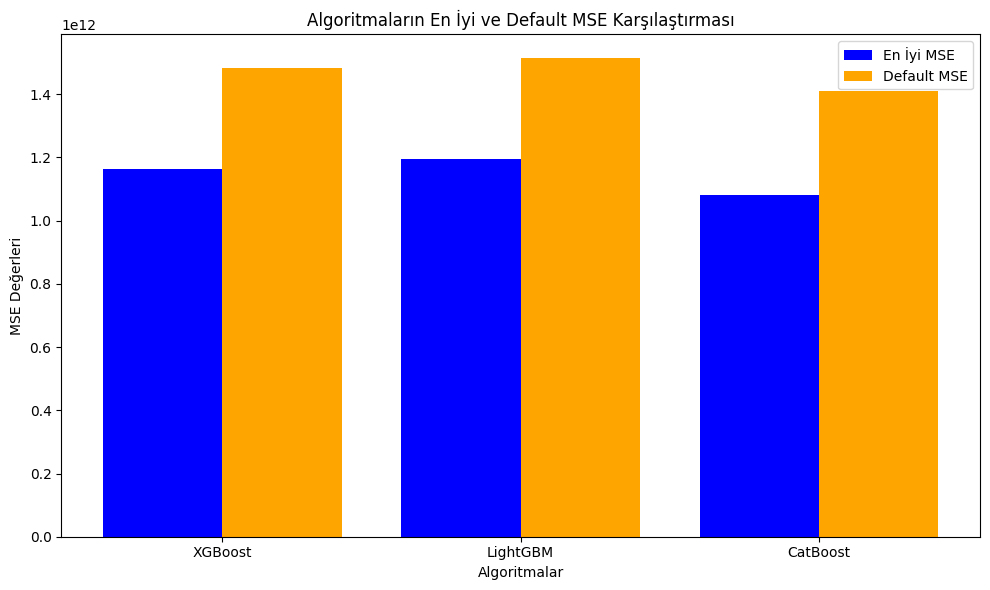

In [ ]:
print("XGBoost en iyi parametreler:", bestParamsXGB)
print("XGBoost en iyi MSE:", bestmseXGB)
print("XGBoost default MSE:", mseXGB)
print("\n")

print("LightGBM en iyi parametreler :", bestParamsLGBM)
print("LightGBM en iyi MSE :", bestmseLGBM)
print("LightGBM default MSE :", mseLGBM)
print("\n")

print("CatBoost en iyi parametreler:", bestParamsCATB)
print("CatBoost en iyi MSE:", bestmseCATB)
print("CatBoost default MSE:", mseCATB)


# grafik oluşturmak için gerekenler
algoritmalar = ['XGBoost', 'LightGBM', 'CatBoost']
bestmseValues = [bestmseXGB, bestmseLGBM, bestmseCATB]
defaultmseValues = [mseXGB, mseLGBM, mseCATB]

plt.figure(figsize=(10, 6))
plt.bar([x for x in range(len(algoritmalar))], bestmseValues, color='blue', width=0.4, label='En İyi MSE')
plt.bar([x + 0.4 for x in range(len(algoritmalar))], defaultmseValues, color='orange', width=0.4, label='Default MSE')
plt.xlabel('Algoritmalar')
plt.ylabel('MSE Değerleri')
plt.title('Algoritmaların En İyi ve Default MSE Karşılaştırması')
plt.xticks([x + 0.2 for x in range(len(algoritmalar))], algoritmalar)
plt.legend()
plt.tight_layout()
plt.show()